In [1]:
%load_ext autoreload

In [2]:
%autoreload
 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.model_selection import train_test_split
from Visualizer import Visualizer
from Preprocessor import Preprocessor
from Model import Model
from TestModel import TestModel
from flaml import AutoML
from subway_clean import Mordi
sns.set_style('darkgrid')
pd.set_option("display.max_columns", None)

In [3]:
preprocessor = Preprocessor()
apartments = preprocessor.apartments

In [4]:
apartments_test = preprocessor.apartments_test
buildings = preprocessor.buildings
buildings_test = preprocessor.buildings_test
merged = preprocessor.merged.copy()
merged_test = preprocessor.merged_test.copy()
labels = merged["price"]
merged_final = pd.concat([merged, merged_test], ignore_index=True)
print(f"The dataframe now has {len(merged_final)} entries")

The dataframe now has 33222 entries


In [5]:
visualizer = Visualizer()
visualizer.list_missing(merged_final.copy())

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 12772 | 38.44%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 6954 | 20.93%
area_living: Amount: 5901 | 17.76%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
layout: Amount: 25010 | 75.28%
ceiling: Amount: 16111 | 48.49%
bathrooms_shared: Amount: 5589 | 16.82%
bathrooms_private: Amount: 5589 | 16.82%
windows_court: Amount: 11560 | 34.8%
windows_street: Amount: 11560 | 34.8%
balconies: Amount: 15355 | 46.22%
loggias: Amount: 15355 | 46.22%
condition: Amount: 13769 | 41.45%
phones: Amount: 120 | 0.36%
building_id: Amount: 0 | 0.0%
new: Amount: 373 | 1.12%
latitude: Amount: 2 | 0.01%
longitude: Amount: 2 | 0.01%
district: Amount: 155 | 0.47%
street: Amount: 0 | 0.0%
address: Amount: 0 | 0.0%
constructed: Amount: 1168 | 3.52%
material: Amount: 5643 | 16.99%
stories: Amount: 0 | 0.0%
elevator_without: Amount: 537 | 1.62%
elevator_passenger: Amount: 537 | 1.62%
elevator_service: Amount: 537 | 1.62%
par

In [6]:
general_removed = preprocessor.general_removal(merged_final.copy())
data = preprocessor.remove_NaNs(general_removed.copy())
visualizer.list_missing(data)

Total length: 33222
id: Amount: 0 | 0.0%
seller: Amount: 0 | 0.0%
price: Amount: 9937 | 29.91%
area_total: Amount: 0 | 0.0%
area_kitchen: Amount: 0 | 0.0%
area_living: Amount: 0 | 0.0%
floor: Amount: 0 | 0.0%
rooms: Amount: 0 | 0.0%
bathrooms_shared: Amount: 0 | 0.0%
bathrooms_private: Amount: 0 | 0.0%
windows_court: Amount: 0 | 0.0%
windows_street: Amount: 0 | 0.0%
phones: Amount: 0 | 0.0%
building_id: Amount: 0 | 0.0%
new: Amount: 0 | 0.0%
latitude: Amount: 0 | 0.0%
longitude: Amount: 0 | 0.0%
district: Amount: 0 | 0.0%
constructed: Amount: 0 | 0.0%
material: Amount: 0 | 0.0%
stories: Amount: 0 | 0.0%
elevator_passenger: Amount: 0 | 0.0%
elevator_service: Amount: 0 | 0.0%
parking: Amount: 0 | 0.0%
garbage_chute: Amount: 0 | 0.0%
heating: Amount: 0 | 0.0%


In [7]:
data = preprocessor.logify(data.copy(), "price")
#data = preprocessor.logify(data.copy(), "area_total")
data = preprocessor.logify(data.copy(), "area_living")
data = preprocessor.remove_zero_values(data.copy(), "area_living")
data = preprocessor.logify(data.copy(), "area_kitchen")

In [8]:
is_outlier = (data["longitude"] > 55) | (data["latitude"] < 54)
outliers = data.copy()[is_outlier]
removed_outliers = preprocessor.fix_latlon_outliers(data.copy(), outliers)

In [9]:
featured = preprocessor.combine_latlon_subway(removed_outliers.copy(),True)
featured = preprocessor.combine_area_rooms(featured.copy())
featured = preprocessor.combine_baths(featured.copy())
featured = preprocessor.combine_windows(featured.copy())
featured = preprocessor.combine_windows(featured.copy(), boolean=True)
featured = preprocessor.combine_latlon(featured.copy())
featured = preprocessor.combine_elevators(featured.copy())
featured = preprocessor.redo_new(featured.copy())
featured = preprocessor.combine_new_constructed_distance(featured.copy())
featured = preprocessor.combine_floor_stories(featured.copy())
featured = preprocessor.combine_district_city_center(featured.copy())
featured = preprocessor.combine_area_total_city_center(featured.copy())
featured = preprocessor.area_score(featured.copy())
featured = preprocessor.apartment_score(featured.copy())
featured = preprocessor.square_diff(featured.copy())

featured = preprocessor.closest_hospital(featured.copy())
featured = preprocessor.closest_park(featured.copy())

featured = preprocessor.distance_luxury_village(featured.copy())
featured = preprocessor.closest_uni(featured.copy())
featured = preprocessor.inside_golden_mile(featured.copy())
featured = preprocessor.distance_from_golden_mile(featured.copy())

featured = preprocessor.inside_khamovniki(featured.copy())
featured = preprocessor.distance_from_khamovniki_center(featured.copy())

featured = preprocessor.inside_yakimanka(featured.copy())
featured = preprocessor.inside_arbat(featured.copy())
featured = preprocessor.inside_tverskoy(featured.copy())

featured = preprocessor.distance_to_closest_powerplant(featured.copy())
featured = preprocessor.distance_to_closest_museum(featured.copy())
featured = preprocessor.distance_to_closest_stadium(featured.copy())
featured = preprocessor.distance_to_closest_theater(featured.copy())
featured = preprocessor.distance_to_closest_church(featured.copy())
featured = preprocessor.distance_to_closest_railway(featured.copy())
featured = preprocessor.distance_to_closest_airport(featured.copy())

featured = preprocessor.distance_from_vnukovo(featured.copy())
featured = preprocessor.distance_from_sheremetyevo(featured.copy())
featured = preprocessor.distance_from_domodedovo(featured.copy())
featured = preprocessor.distance_from_zhukovsky(featured.copy())
featured = preprocessor.distance_from_ostafyevo(featured.copy())

featured = preprocessor.bathroom_fraction(featured.copy())
featured = preprocessor.floor_fraction(featured.copy())

#visualizer.price_correlation(featured)


#categorical = preprocessor.split_categorical_features(featured.copy(), ["seller", "district","material", "has_elevator"])
#categorical = preprocessor.split_categorical_features(featured.copy(), ["district", "material"])

In [10]:
featured = preprocessor.logify(featured.copy(),"area_score")
featured = preprocessor.logify(featured.copy(),"area_total_distance")
featured = preprocessor.logify(featured.copy(),"scaled_constructed")
featured = preprocessor.logify(featured.copy(),"distance_center")
featured = preprocessor.logify(featured.copy(),"closest_park")
featured = preprocessor.logify(featured.copy(),"closest_uni")
featured = preprocessor.logify(featured.copy(),"closest_hospital")
featured = preprocessor.logify(featured.copy(),"distance_luxurary_village")
featured = preprocessor.logify(featured.copy(),"distance_khamovniki_center")
featured = preprocessor.logify(featured.copy(),"distance_closest_powerplant")
featured = preprocessor.logify(featured.copy(),"distance_golden_mile")
featured = preprocessor.logify(featured.copy(),"distance_closest_museum")
featured = preprocessor.logify(featured.copy(),"distance_closest_stadium")
featured = preprocessor.logify(featured.copy(),"distance_closest_theater")
featured = preprocessor.logify(featured.copy(),"distance_closest_church")
featured = preprocessor.logify(featured.copy(),"distance_closest_railway")
featured = preprocessor.logify(featured.copy(),"distance_closest_airport")
featured = preprocessor.logify(featured.copy(),"distance_from_vnukovo_airport")
featured = preprocessor.logify(featured.copy(),"distance_from_sheremetyevo_airport")
featured = preprocessor.logify(featured.copy(),"distance_from_domodedovo_airport")
featured = preprocessor.logify(featured.copy(),"distance_from_zhukovsky_airport")
featured = preprocessor.logify(featured.copy(),"distance_from_ostafyevo_airport")

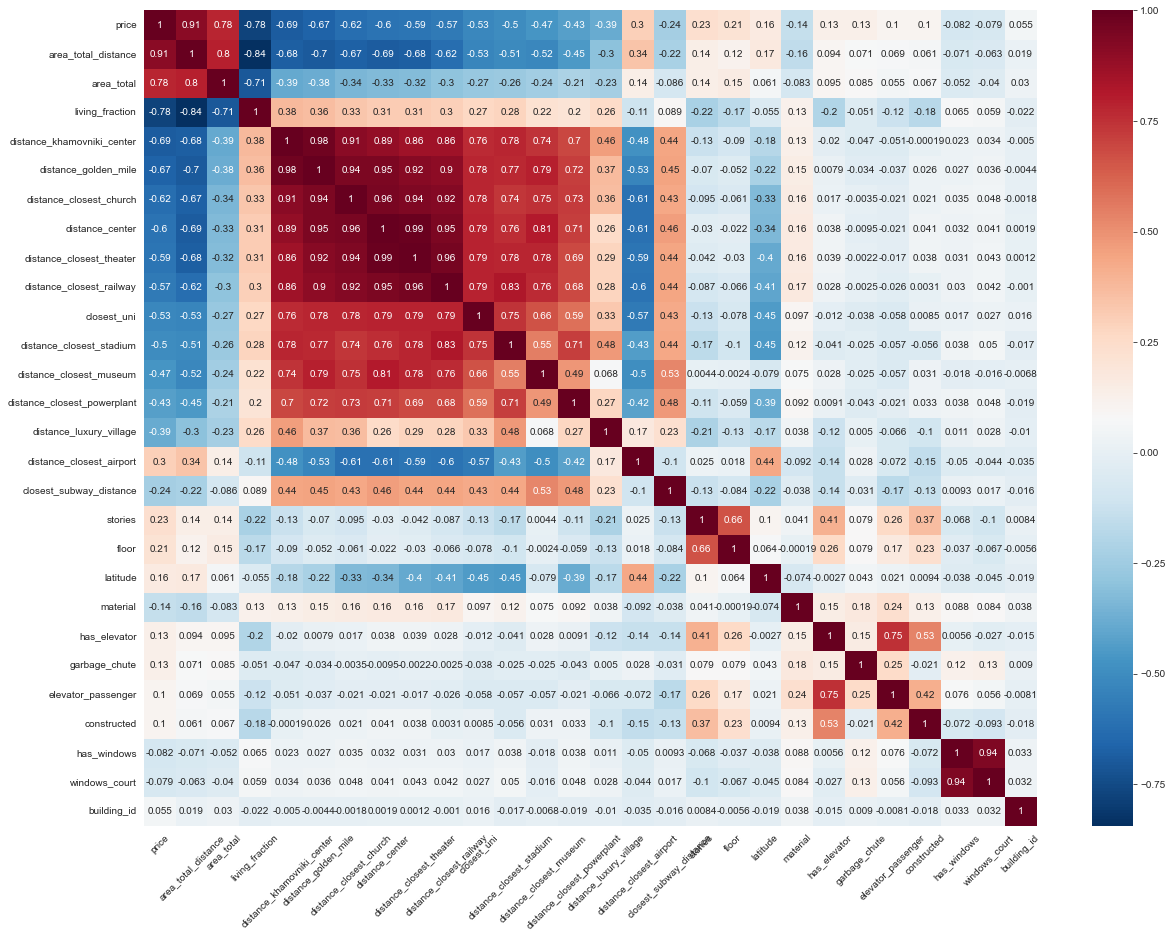

In [11]:
#categorical = preprocessor.split_categorical_features(featured.copy(), ["district", "material"])
#lmao= preprocessor.remove_labels(categorical.copy(), ["material_1.0","material_6.0","district_1.0","district_6.0","district_8.0","has_elevator_1","seller_3.0","material_0.0","district_2.0","district_5.0","district_9.0"])

last = preprocessor.remove_labels(featured.copy(), ["inside_golden_mile","closest_museum","closest_stadium","area_score","area_kitchen","area_living","square_diff","kitchen_fraction","closest_park","rooms","elevator_service","bathroom_fraction","bathroom_amount","bathrooms_shared","district_distance","inside_khamovniki","district","floor_stories","closest_hospital","apartment_score","seller","inside_arbat","distance_from_sheremetyevo_airport","inside_yakimanka","inside_tverskoy","distance_from_domodedovo_airport","bathrooms_private","new","distance_from_ostafyevo_airport","distance_from_zhukovsky_airport","avg_room_size","scaled_constructed","phones","heating","distance_from_vnukovo_airport","parking","floor_fraction","longitude","id","windows_street"])

visualizer.price_correlation(last)

In [12]:
# Seperating training and test data
train_data = last[:23285].copy()
labels = train_data["price"]
test_data = last[23285:].copy()
test_data.drop("price", 1, inplace=True)
print("Split data into train and test")

# Splitting training data into training and validation, removed the price for each of them afterwards
x_train, x_test, y_train, y_test = train_test_split(train_data, labels, stratify=train_data["price"].round(), test_size=0.30)
x_train.drop("price", 1, inplace=True)
x_test.drop("price", 1, inplace=True)
print("Validation data created and price dropped")
print("The number of features are now:", x_train.shape[1])

print("Fitting model...")
model = TestModel(x_train, y_train)
pipeline = model.fit()
test_pred = np.round([np.expm1(pred) for pred in model.predict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in model.predict(test_data)]
model.save_predictions(pred)

Split data into train and test
Validation data created and price dropped
The number of features are now: 27
Fitting model...
[15:36:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { eva_metric } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Fitting complete
RMLSE: 0.1614008009497572


,id,price_prediction
0,23285,28498100.0
1,23286,8383133.0
2,23287,6001642.5
3,23288,9411667.0
4,23289,5032487.0
...,...,...
9932,33217,27616248.0
9933,33218,18567956.0
9934,33219,9704205.0
9935,33220,9485140.0


In [13]:
automl_model = TestModel(x_train, y_train)
automl_model.autoMLfit(x_train, y_train, ["lgbm","xgboost"],time=60,ensemble=True)

[flaml.automl: 11-18 15:37:01] {1485} INFO - Data split method: uniform
[flaml.automl: 11-18 15:37:01] {1489} INFO - Evaluation method: holdout
[flaml.automl: 11-18 15:37:01] {1540} INFO - Minimizing error metric: customized metric
[flaml.automl: 11-18 15:37:01] {1577} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost']
[flaml.automl: 11-18 15:37:01] {1826} INFO - iteration 0, current learner lgbm
[flaml.automl: 11-18 15:37:01] {1943} INFO - Estimated sufficient time budget=1198s. Estimated necessary time budget=1s.
[flaml.automl: 11-18 15:37:01] {2023} INFO -  at 0.4s,	estimator lgbm's best error=0.0360,	best estimator lgbm's best error=0.0360
[flaml.automl: 11-18 15:37:01] {1826} INFO - iteration 1, current learner lgbm
[flaml.automl: 11-18 15:37:01] {2023} INFO -  at 0.5s,	estimator lgbm's best error=0.0360,	best estimator lgbm's best error=0.0360
[flaml.automl: 11-18 15:37:01] {1826} INFO - iteration 2, current learner lgbm
[flaml.automl: 11-18 15:37:01] {2023} INFO -  at

In [14]:
test_pred = np.round([np.expm1(pred) for pred in automl_model.autoMLpredict(x_test)])
test_labels = np.round([np.expm1(lab)for lab in y_test])
print("Fitting complete")

res = pd.DataFrame([(test_labels[i], test_pred[i]) for i in range(len(test_pred))], columns=["actual", "prediction"])
print("RMLSE: %s" % automl_model.root_mean_squared_log_error(test_labels, test_pred))
res.to_csv("./split.csv", index=False)

pred = [np.expm1(p) for p in automl_model.predict(test_data)]
automl_model.save_predictions(pred)
automl_model.autoML_print_best_model()

Fitting complete
RMLSE: 0.14174731202431523
best model xgboost
configs {'n_estimators': 374, 'max_leaves': 28, 'min_child_weight': 11.101864586090514, 'learning_rate': 0.12229148765139466, 'subsample': 0.8895588746662894, 'colsample_bylevel': 0.4280572638757817, 'colsample_bytree': 0.5344640556302928, 'reg_alpha': 0.018278623959341735, 'reg_lambda': 0.3650737309296021}
